In [1]:
import numpy as np
from glob import glob
import os
import matplotlib.pyplot as plt

In [2]:
ls ../monit_npy/

REGRESSION_nn_rhorho_Variant-All_Unweighted_False_NO/
nn_rhorho_Variant-All_Unweighted_False_NO_NUM_CLASSES_10/
nn_rhorho_Variant-All_Unweighted_False_NO_NUM_CLASSES_11/
nn_rhorho_Variant-All_Unweighted_False_NO_NUM_CLASSES_12/
nn_rhorho_Variant-All_Unweighted_False_NO_NUM_CLASSES_13/
nn_rhorho_Variant-All_Unweighted_False_NO_NUM_CLASSES_14/
nn_rhorho_Variant-All_Unweighted_False_NO_NUM_CLASSES_15/
nn_rhorho_Variant-All_Unweighted_False_NO_NUM_CLASSES_16/
nn_rhorho_Variant-All_Unweighted_False_NO_NUM_CLASSES_17/
nn_rhorho_Variant-All_Unweighted_False_NO_NUM_CLASSES_18/
nn_rhorho_Variant-All_Unweighted_False_NO_NUM_CLASSES_19/
nn_rhorho_Variant-All_Unweighted_False_NO_NUM_CLASSES_2/
nn_rhorho_Variant-All_Unweighted_False_NO_NUM_CLASSES_20/
nn_rhorho_Variant-All_Unweighted_False_NO_NUM_CLASSES_21/
nn_rhorho_Variant-All_Unweighted_False_NO_NUM_CLASSES_21_WEIGHTS_SUBS[0, 10]/
nn_rhorho_Variant-All_Unweighted_False_NO_NUM_CLASSES_21_WEIGHTS_SUBS[0, 2]/
nn_rhorho_Variant-All_Unweighted_False

In [3]:
filenames = [f'../monit_npy/nn_rhorho_Variant-All_Unweighted_False_NO_NUM_CLASSES_{i}' for i in range(2,51)]

In [4]:
def get_filename_for_class(class_num, subset=None):
    d = f'../monit_npy/nn_rhorho_Variant-All_Unweighted_False_NO_NUM_CLASSES_{class_num}'
    if subset:
        d += "_WEIGHTS_SUBS" + str(subset)
    return d

In [5]:
ls ../monit_npy/nn_rhorho_Variant-All_Unweighted_False_NO_NUM_CLASSES_50

softmax_calc_w.npy   softmax_preds_w.npy


In [6]:
filenames[0]

'../monit_npy/nn_rhorho_Variant-All_Unweighted_False_NO_NUM_CLASSES_2'

In [52]:
def calc_min_distances(pred_arg_maxs, calc_arg_maxs, num_class):
    min_distances = np.zeros(len(calc_arg_maxs))
    for i in range(len(calc_arg_maxs)):
        dist = pred_arg_maxs[i] - calc_arg_maxs[i]
        if np.abs(num_class - 1 + pred_arg_maxs[i] - calc_arg_maxs[i])<np.abs(dist):
            dist = num_class - 1 + pred_arg_maxs[i] - calc_arg_maxs[i]
        if np.abs(-num_class + 1 + pred_arg_maxs[i] - calc_arg_maxs[i])<np.abs(dist):
            dist = -num_class + 1 + pred_arg_maxs[i] - calc_arg_maxs[i]
        min_distances[i]  = dist
    return min_distances

In [55]:
def calculate_metrics(directory, num_class):
    calc_w = np.load(os.path.join(directory, 'softmax_calc_w.npy'))
    preds_w = np.load(os.path.join(directory, 'softmax_preds_w.npy'))
    calc_w = calc_w / np.tile(np.reshape(np.sum(calc_w, axis=1), (-1, 1)), (1, num_class))
    pred_arg_maxs = np.argmax(preds_w, axis=1)
    calc_arg_maxs = np.argmax(calc_w, axis=1)
    
    min_distances = calc_min_distances(pred_arg_maxs, calc_arg_maxs, num_class)
    
    acc0 = (np.abs(min_distances) <= 0).mean()
    acc1 = (np.abs(min_distances) <= 1).mean()
    acc2 = (np.abs(min_distances) <= 2).mean()
    acc3 = (np.abs(min_distances) <= 3).mean()
    
    mean_error = np.mean(np.abs(min_distances))
    l1_delta_w = np.mean(np.abs(calc_w - preds_w))
    l2_delta_w = np.sqrt(np.mean((calc_w - preds_w)**2))
    
    return np.array([acc0, acc1, acc2, acc3, mean_error, l1_delta_w, l2_delta_w])

In [56]:
metrics = [calculate_metrics(filenames[i], i+2) for i in range(49)]

In [57]:
metrics = np.stack(metrics)

# Accuracy

Text(0,0.5,'Accuracy')

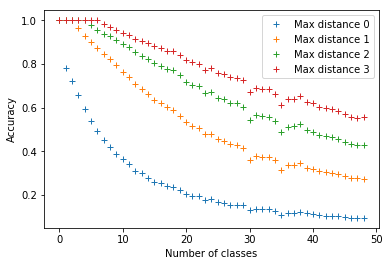

In [58]:
plt.plot(metrics[:, 0],'+', label='Max distance 0')
plt.plot(metrics[:, 1],'+', label='Max distance 1')
plt.plot(metrics[:, 2],'+', label='Max distance 2')
plt.plot(metrics[:, 3],'+', label='Max distance 3')
plt.legend(loc='upper right')
plt.xlabel('Number of classes')
plt.ylabel('Accuracy')

# Mean error

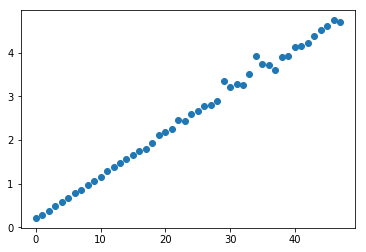

In [59]:
plt.plot(metrics[1:, 4], 'o')



# L1 Distance

Text(0,0.5,'l1')

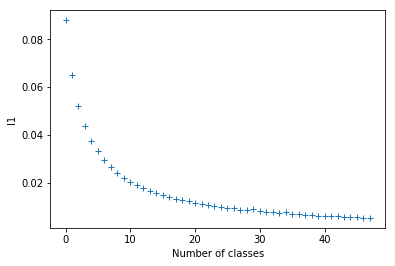

In [60]:
plt.plot(metrics[1:, 5], '+')
plt.xlabel("Number of classes")
plt.ylabel('l1')

# L2 Distance

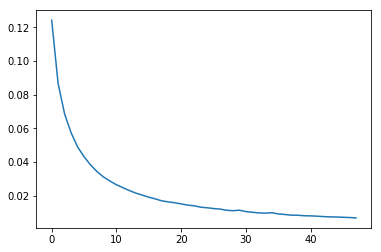

In [61]:
plt.plot(metrics[1:, 6])

# ROC AUC score

In [14]:
from sklearn.metrics import roc_auc_score
def calculate_roc_auc(pred_w, calc_w, index_a, index_b):
    n, num_classes = calc_w.shape
    true_labels = np.concatenate([np.ones(n), np.zeros(n)])
    preds = np.concatenate([pred_w[:, index_a], pred_w[:, index_a]])
    weights = np.concatenate([calc_w[:, index_a], calc_w[:, index_b]])

    return roc_auc_score(true_labels, preds, sample_weight=weights)

In [15]:
def test_roc_auc(directory, num_class):
    calc_w = np.load(os.path.join(directory, 'softmax_calc_w.npy'))
    preds_w = np.load(os.path.join(directory, 'softmax_preds_w.npy'))
    for i in range(0, num_class):
         print(i, 'roc_auc: {}'.format(calculate_roc_auc(preds_w, calc_w, 0, i)), 'maxroc_auc: {}'.format(calculate_roc_auc(calc_w, calc_w, 0, i)))

In [16]:
i = 21
test_roc_auc(get_filename_for_class(i), i)

0 roc_auc: 0.49999999999999567 maxroc_auc: 0.5000000000000064
1 roc_auc: 0.5048067364824772 maxroc_auc: 0.5055437905866971
2 roc_auc: 0.5193160890064648 maxroc_auc: 0.5213842940994315
3 roc_auc: 0.542106919271242 maxroc_auc: 0.5459702471320407
4 roc_auc: 0.5709580477161167 maxroc_auc: 0.5769055838179316
5 roc_auc: 0.6030619663019495 maxroc_auc: 0.6111799506498055
6 roc_auc: 0.6352933285011289 maxroc_auc: 0.6454566069027339
7 roc_auc: 0.6645083290751571 maxroc_auc: 0.6763920917949123
8 roc_auc: 0.687848152201201 maxroc_auc: 0.7009590049115344
9 roc_auc: 0.7030184242088673 maxroc_auc: 0.7167420249191476
10 roc_auc: 0.7085174844611754 maxroc_auc: 0.72217833564523
11 roc_auc: 0.7037897456394488 maxroc_auc: 0.7167174215865095
12 roc_auc: 0.6892867054269389 maxroc_auc: 0.7008819935460375
13 roc_auc: 0.6664270908353371 maxroc_auc: 0.6762213760598018
14 roc_auc: 0.6374583547421923 maxroc_auc: 0.6451601543254943
15 roc_auc: 0.6052329275373992 maxroc_auc: 0.6107567659019254
16 roc_auc: 0.5729225

In [17]:
i = 21
test_roc_auc(get_filename_for_class(i), i)

0 roc_auc: 0.49999999999999567 maxroc_auc: 0.5000000000000064
1 roc_auc: 0.5048067364824772 maxroc_auc: 0.5055437905866971
2 roc_auc: 0.5193160890064648 maxroc_auc: 0.5213842940994315
3 roc_auc: 0.542106919271242 maxroc_auc: 0.5459702471320407
4 roc_auc: 0.5709580477161167 maxroc_auc: 0.5769055838179316
5 roc_auc: 0.6030619663019495 maxroc_auc: 0.6111799506498055
6 roc_auc: 0.6352933285011289 maxroc_auc: 0.6454566069027339
7 roc_auc: 0.6645083290751571 maxroc_auc: 0.6763920917949123
8 roc_auc: 0.687848152201201 maxroc_auc: 0.7009590049115344
9 roc_auc: 0.7030184242088673 maxroc_auc: 0.7167420249191476
10 roc_auc: 0.7085174844611754 maxroc_auc: 0.72217833564523
11 roc_auc: 0.7037897456394488 maxroc_auc: 0.7167174215865095
12 roc_auc: 0.6892867054269389 maxroc_auc: 0.7008819935460375
13 roc_auc: 0.6664270908353371 maxroc_auc: 0.6762213760598018
14 roc_auc: 0.6374583547421923 maxroc_auc: 0.6451601543254943
15 roc_auc: 0.6052329275373992 maxroc_auc: 0.6107567659019254
16 roc_auc: 0.5729225

## Baseline

In [18]:
i = 21
subset = [0,6] # Run with option --WEIGHTS_SUBSET [0,6]
test_roc_auc(get_filename_for_class(i, subset), 2)

0 roc_auc: 0.4999999999999933 maxroc_auc: 0.5000000000000052
1 roc_auc: 0.6639896560945292 maxroc_auc: 0.6454566069027331


In [19]:
i = 21
subset = [0,10] # Run with option --WEIGHTS_SUBSET [0,10]
test_roc_auc(get_filename_for_class(i, subset), 2)

0 roc_auc: 0.5000000000000063 maxroc_auc: 0.5000000000000052
1 roc_auc: 0.701805957934322 maxroc_auc: 0.7221783356452286


In [20]:
i = 21
subset = [0,2] # Run with option --WEIGHTS_SUBSET [0,2]
test_roc_auc(get_filename_for_class(i, subset), 2)

0 roc_auc: 0.4999999999999986 maxroc_auc: 0.5000000000000052
1 roc_auc: 0.5568512762550901 maxroc_auc: 0.521384294099431


In [21]:
i = 21
subset = [0,8] # Run with option --WEIGHTS_SUBSET [0,8]
test_roc_auc(get_filename_for_class(i, subset), 2)

0 roc_auc: 0.4999999999999992 maxroc_auc: 0.5000000000000052
1 roc_auc: 0.6897154024886555 maxroc_auc: 0.7009590049115341


# Accuracy distance

In [64]:
def plot_distr(directory, num_class):
    calc_w = np.load(os.path.join(directory, 'softmax_calc_w.npy'))
    preds_w = np.load(os.path.join(directory, 'softmax_preds_w.npy'))
    pred_arg_maxs = np.argmax(preds_w, axis=1)
    calc_arg_maxs = np.argmax(calc_w, axis=1)
    min_distances = calc_min_distances(pred_arg_maxs, calc_arg_maxs, num_class)
    
    plt.hist(min_distances, bins=num_class-1, histtype='step')
    plt.xlabel('Prediction error distance')
    

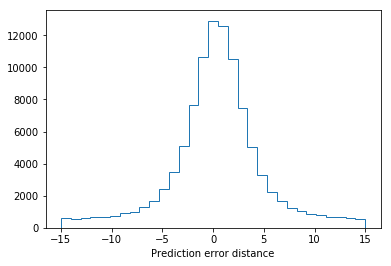

In [65]:
i = 30
plot_distr(filenames[i], i+2)

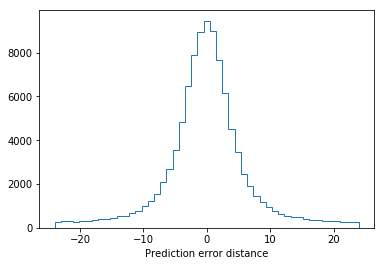

In [66]:
i = 48
plot_distr(filenames[i], i+2)

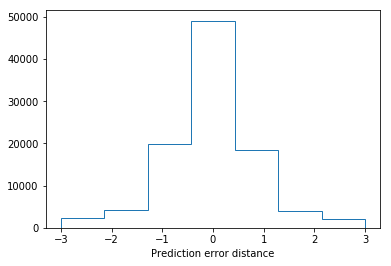

In [67]:
i = 6
plot_distr(filenames[i], i+2)

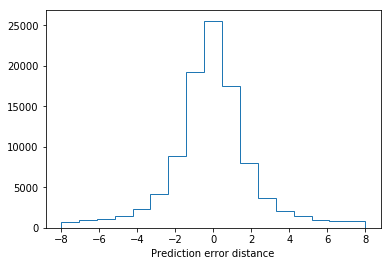

In [68]:
i = 16
plot_distr(filenames[i], i+2)